# Vignetting analysis for EPIC

This analysis follows on a couple of early studies:

* [Statistical evaluation of the flux cross-calibration of the XMM-EPIC (Mateos et al. 2009)](https://ui.adsabs.harvard.edu/abs/2009A%26A...496..879M/abstract)
* [The non-linear X-ray/UV relation in AGNs: contribution of instrumental effects on the X-ray variability (Elisabeta Lusso, 2018)](https://ui.adsabs.harvard.edu/abs/2019AN....340..267L/abstract)



In [1]:
import os

import numpy as np

from astropy.table import Table
import pandas as pd
import altair as alt

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

home = os.path.expanduser('~')

## Energy bands used in 3XMM

```Basic energy bands: 	
1 	= 	0.2 -   0.5 keV 	 
2 	= 	0.5 -   1.0 keV 	  	 
3 	= 	1.0 -   2.0 keV 	  	 
4 	= 	2.0 -   4.5 keV 	  	 
5 	= 	4.5 - 12.0 keV 	  	 
Broad energy bands: 	
6 	= 	0.2 -   2.0 keV 	  	soft band, no images made, not used
7 	= 	2.0 - 12.0 keV 	  	hard band, no images made, not used
8 	= 	0.2 - 12.0 keV 	  	total band
9 	= 	0.5 -   4.5 keV 	  	XID band
```

In [2]:
#
# define the energy ranges for info
#
bands = {1:'[0.2-0.5] keV',2:'[0.5-1.0] keV',3:'[1.0-2.0] keV',4:'[2.0-4.5] keV',5:'[4.5-12.0] keV',\
        8:'[0.2-12.0] keV'}

In [3]:
#
# read the 3XMM-DR8 catalogue
#
wdir = f"{home}/XMM/3XMM"
t3 = Table.read(f'{wdir}/3XMM_DR8cat_v1.0.fits.gz')

## Source selection

We apply the following selection of sources from the `3XMM-DR8` catalogue, where `x` is one of `M1, M2` or `PN`:
1. good detection, i.e. `SUM_FLAG == 0`
2. point-like sources, i.e. `EP_EXTENT == 0`
3. at off-axis angles <= 12 arcmin, i.e. `x_OFFAX <= 12`
4. flux in [2,12] keV <= 6.0e-12 erg/cm2/s, i.e. `(x_4_FLUX + x_5_FLUX) <= 6.0e-12`, in order to avoid pile-up sources.
5. `CONFUSED == false`
6. `HIGH_BACKGROUND == false`
7. at least 200 source counts in band 8, i.e. `EP_8_CTS >= 200`
8. not too faint sources, i.e. `x_5_FLUX >= 1.0e-15`
9. High SNR in band 5, i.e. `x_5_FLUX/x_5_FLUX_ERR >= 5`

In [4]:
ntot = len(t3)
m1 = t3['SUM_FLAG'] == 0
#
m2 = t3['EP_EXTENT'] == 0
#
m3_m1 = t3['M1_OFFAX'] <= 12.0
m3_m2 = t3['M2_OFFAX'] <= 12.0
m3_pn = t3['PN_OFFAX'] <= 12.0
#
m4_m1 = (t3['M1_4_FLUX'] + t3['M1_5_FLUX']) <= 6.0e-12
m4_m2 = (t3['M2_4_FLUX'] + t3['M2_5_FLUX']) <= 6.0e-12
m4_pn = (t3['PN_4_FLUX'] + t3['PN_5_FLUX']) <= 6.0e-12
#
m5 = t3['CONFUSED'] == 0
#
m6 = t3['HIGH_BACKGROUND'] == 0
#
m7 = t3['EP_8_CTS'] >= 200.0
#
m8_m1 = (t3['M1_5_FLUX']) >= 1.0e-15
m8_m2 = (t3['M2_5_FLUX']) >= 1.0e-15
m8_pn = (t3['PN_5_FLUX']) >= 1.0e-15
#
m9_m1 = (t3['M1_5_FLUX']/t3['M1_5_FLUX_ERR']) >= 5.0
m9_m2 = (t3['M2_5_FLUX']/t3['M2_5_FLUX_ERR']) >= 5.0
m9_pn = (t3['PN_5_FLUX']/t3['PN_5_FLUX_ERR']) >= 5.0
#
xfilter = m1*m2*m3_m1*m3_m2*m3_pn*m4_m1*m4_m2*m4_pn*m5*m6*m7*m8_m1*m8_m2*m8_pn*m9_m1*m9_m2*m9_pn
#
ix = np.where(xfilter)[0]
nx = len(ix)
print (f"Found {nx} out of {ntot} ({100*nx/ntot:.2f} %) 3XMM-DR8 sources with the filtering criteria.")

/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


Found 1697 out of 775153 (0.22 %) 3XMM-DR8 sources with the filtering criteria.


In [5]:
#
# extract the selection as a table
#
tsel = t3[ix]

In [6]:
ix = np.where(tsel['M1_5_FLUX']/tsel['PN_5_FLUX'] >= 10.0)
tsel[ix[0]]

DETID,SRCID,DR3SRCID,DR3DETID,DR3DETDIST,DR3SRCDIST,DR3MULT,DR4SRCID,DR4DETID,DR4DETDIST,DR4SRCDIST,DR4MULT,IAUNAME,SRC_NUM,OBS_ID,REVOLUT,MJD_START,MJD_STOP,OBS_CLASS,PN_FILTER,M1_FILTER,M2_FILTER,PN_SUBMODE,M1_SUBMODE,M2_SUBMODE,RA,DEC,POSERR,LII,BII,RADEC_ERR,SYSERRCC,REFCAT,POSCOROK,RA_UNC,DEC_UNC,CCDPN,PN_RAWX,PN_RAWY,CCDM1,M1_RAWX,M1_RAWY,CCDM2,M2_RAWX,M2_RAWY,EP_1_FLUX,EP_1_FLUX_ERR,EP_2_FLUX,EP_2_FLUX_ERR,EP_3_FLUX,EP_3_FLUX_ERR,EP_4_FLUX,EP_4_FLUX_ERR,EP_5_FLUX,EP_5_FLUX_ERR,EP_8_FLUX,EP_8_FLUX_ERR,EP_9_FLUX,EP_9_FLUX_ERR,PN_1_FLUX,PN_1_FLUX_ERR,PN_2_FLUX,PN_2_FLUX_ERR,PN_3_FLUX,PN_3_FLUX_ERR,PN_4_FLUX,PN_4_FLUX_ERR,PN_5_FLUX,PN_5_FLUX_ERR,PN_8_FLUX,PN_8_FLUX_ERR,PN_9_FLUX,PN_9_FLUX_ERR,M1_1_FLUX,M1_1_FLUX_ERR,M1_2_FLUX,M1_2_FLUX_ERR,M1_3_FLUX,M1_3_FLUX_ERR,M1_4_FLUX,M1_4_FLUX_ERR,M1_5_FLUX,M1_5_FLUX_ERR,M1_8_FLUX,M1_8_FLUX_ERR,M1_9_FLUX,M1_9_FLUX_ERR,M2_1_FLUX,M2_1_FLUX_ERR,M2_2_FLUX,M2_2_FLUX_ERR,M2_3_FLUX,M2_3_FLUX_ERR,M2_4_FLUX,M2_4_FLUX_ERR,M2_5_FLUX,M2_5_FLUX_ERR,M2_8_FLUX,M2_8_FLUX_ERR,M2_9_FLUX,M2_9_FLUX_ERR,EP_8_RATE,EP_8_RATE_ERR,EP_9_RATE,EP_9_RATE_ERR,PN_1_RATE,PN_1_RATE_ERR,PN_2_RATE,PN_2_RATE_ERR,PN_3_RATE,PN_3_RATE_ERR,PN_4_RATE,PN_4_RATE_ERR,PN_5_RATE,PN_5_RATE_ERR,PN_8_RATE,PN_8_RATE_ERR,PN_9_RATE,PN_9_RATE_ERR,M1_1_RATE,M1_1_RATE_ERR,M1_2_RATE,M1_2_RATE_ERR,M1_3_RATE,M1_3_RATE_ERR,M1_4_RATE,M1_4_RATE_ERR,M1_5_RATE,M1_5_RATE_ERR,M1_8_RATE,M1_8_RATE_ERR,M1_9_RATE,M1_9_RATE_ERR,M2_1_RATE,M2_1_RATE_ERR,M2_2_RATE,M2_2_RATE_ERR,M2_3_RATE,M2_3_RATE_ERR,M2_4_RATE,M2_4_RATE_ERR,M2_5_RATE,M2_5_RATE_ERR,M2_8_RATE,M2_8_RATE_ERR,M2_9_RATE,M2_9_RATE_ERR,EP_8_CTS,EP_8_CTS_ERR,PN_8_CTS,PN_8_CTS_ERR,M1_8_CTS,M1_8_CTS_ERR,M2_8_CTS,M2_8_CTS_ERR,EP_8_DET_ML,EP_9_DET_ML,PN_1_DET_ML,PN_2_DET_ML,PN_3_DET_ML,PN_4_DET_ML,PN_5_DET_ML,PN_8_DET_ML,PN_9_DET_ML,M1_1_DET_ML,M1_2_DET_ML,M1_3_DET_ML,M1_4_DET_ML,M1_5_DET_ML,M1_8_DET_ML,M1_9_DET_ML,M2_1_DET_ML,M2_2_DET_ML,M2_3_DET_ML,M2_4_DET_ML,M2_5_DET_ML,M2_8_DET_ML,M2_9_DET_ML,EP_EXTENT,EP_EXTENT_ERR,EP_EXTENT_ML,EP_HR1,EP_HR1_ERR,EP_HR2,EP_HR2_ERR,EP_HR3,EP_HR3_ERR,EP_HR4,EP_HR4_ERR,PN_HR1,PN_HR1_ERR,PN_HR2,PN_HR2_ERR,PN_HR3,PN_HR3_ERR,PN_HR4,PN_HR4_ERR,M1_HR1,M1_HR1_ERR,M1_HR2,M1_HR2_ERR,M1_HR3,M1_HR3_ERR,M1_HR4,M1_HR4_ERR,M2_HR1,M2_HR1_ERR,M2_HR2,M2_HR2_ERR,M2_HR3,M2_HR3_ERR,M2_HR4,M2_HR4_ERR,PN_1_EXP,PN_2_EXP,PN_3_EXP,PN_4_EXP,PN_5_EXP,M1_1_EXP,M1_2_EXP,M1_3_EXP,M1_4_EXP,M1_5_EXP,M2_1_EXP,M2_2_EXP,M2_3_EXP,M2_4_EXP,M2_5_EXP,PN_1_BG,PN_2_BG,PN_3_BG,PN_4_BG,PN_5_BG,M1_1_BG,M1_2_BG,M1_3_BG,M1_4_BG,M1_5_BG,M2_1_BG,M2_2_BG,M2_3_BG,M2_4_BG,M2_5_BG,PN_1_VIG,PN_2_VIG,PN_3_VIG,PN_4_VIG,PN_5_VIG,M1_1_VIG,M1_2_VIG,M1_3_VIG,M1_4_VIG,M1_5_VIG,M2_1_VIG,M2_2_VIG,M2_3_VIG,M2_4_VIG,M2_5_VIG,PN_ONTIME,M1_ONTIME,M2_ONTIME,EP_ONTIME,PN_OFFAX,M1_OFFAX,M2_OFFAX,EP_OFFAX,PN_MASKFRAC,M1_MASKFRAC,M2_MASKFRAC,DIST_NN,SUM_FLAG,EP_FLAG,PN_FLAG,M1_FLAG,M2_FLAG,TSERIES,SPECTRA,EP_CHI2PROB,PN_CHI2PROB,M1_CHI2PROB,M2_CHI2PROB,PN_FVAR,PN_FVARERR,M1_FVAR,M1_FVARERR,M2_FVAR,M2_FVARERR,VAR_FLAG,VAR_EXP_ID,VAR_INST_ID,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,HIGH_BACKGROUND
,,,,arcsec,arcsec,,,,arcsec,arcsec,,,,,orbit,d,d,,,,,,,,deg,deg,arcsec,deg,deg,arcsec,arcsec,,,deg,deg,,,,,,,,,,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg

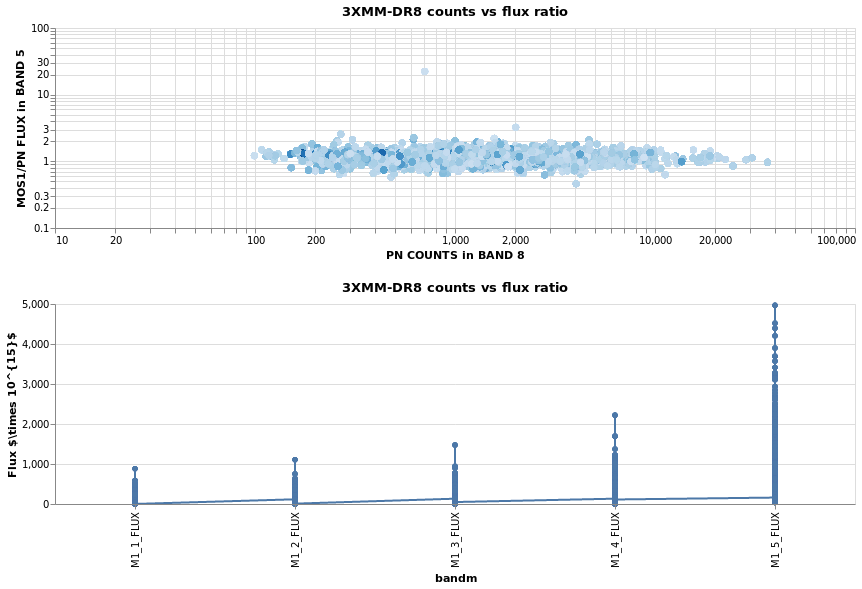

In [91]:
#fig, ax = plt.subplots(figsize=(15,10))
#ax.loglog(tsel['PN_8_CTS'],tsel['M1_5_FLUX']/tsel['PN_5_FLUX'],'bo')
#ax.grid()
#ax.set_xlabel('PN COUNTS in BAND 8')
#ax.set_ylabel('MOS1/PN FLUX BAND 5')
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
#
# interactive plot with altair
#
# extract some relevant columns
#
xtab = tsel['DETID','SRCID','DR3SRCID',\
            'M1_1_FLUX','M1_2_FLUX','M1_3_FLUX','M1_4_FLUX','M1_5_FLUX',\
            'PN_1_FLUX','PN_2_FLUX','PN_3_FLUX','PN_4_FLUX','PN_5_FLUX',\
            'PN_8_CTS', 'PN_ONTIME', 'M1_ONTIME', 'DIST_NN'].to_pandas()
xtab['ratio_5'] = xtab['M1_5_FLUX']/xtab['PN_5_FLUX']

selector = alt.selection_single(empty='all', fields=['DETID'])

base = alt.Chart(xtab).properties(
    title="3XMM-DR8 counts vs flux ratio",width=800,height=200).add_selection(selector).transform_fold(
    ['M1_1_FLUX','M1_2_FLUX','M1_3_FLUX','M1_4_FLUX','M1_5_FLUX'],
    as_=["bandm","mos1"]).transform_fold(
    ['PN_1_FLUX','PN_2_FLUX','PN_3_FLUX','PN_4_FLUX','PN_5_FLUX'],
    as_=["bandq","pn"])

points = base.mark_point(filled=True, size=50).encode(
    x=alt.X(
        'PN_8_CTS',
        scale=alt.Scale(type='log'),
        axis=alt.Axis(title='PN COUNTS in BAND 8')
    ),
    y=alt.Y(
        'ratio_5',
        scale=alt.Scale(type='log'),
        axis=alt.Axis(title="MOS1/PN FLUX in BAND 5")
    ),
    color=alt.condition(selector, 'DIST_NN', alt.value('lightgray'), legend=None),
    tooltip=['DR3SRCID','PN_5_FLUX','M1_5_FLUX','M1_ONTIME','PN_ONTIME','DIST_NN']
).interactive()

#
# now the SED
sed1 = base.mark_line(point=True).encode(
    x='bandm:N',
    y=alt.Y(
        'fx:Q',
        #scale=alt.Scale(type='log'),
        axis=alt.Axis(title=r'Flux $\times 10^{15}$')
   )).transform_calculate(
    fx='datum.mos1*1.0e15').transform_filter(
    selector
    )

sed2 = base.mark_line(point=True).encode(
    x='bandp:N',
    y=alt.Y(
        'fy:Q',
        #scale=alt.Scale(type='log'),
        #axis=alt.Axis(title='Flux')
   )).transform_calculate(
    fy='datum.pn*1.0e15').transform_filter(
    selector
    )

alt.vconcat(points,(sed1))
#sed

In [1]:
qdata = pd.DataFrame({'x1': [0.2, 0.5, 1.0, 2.0, 4.5],
                      'x2': [0.5,1.0,2.0,4.5,12.0],
                      #'id': [tsel['DETID']],
                      #'pn8cts': tsel['PN_8_CTS'],
                      #'ratio': tsel['M1_5_FLUX']/tsel['PN_5_FLUX'],
                     'fmos': [tsel['M1_1_FLUX'],tsel['M1_2_FLUX'],tsel['M1_3_FLUX'],tsel['M1_4_FLUX'],tsel['M1_5_FLUX']],
                     'fpn': [tsel['PN_1_FLUX'],tsel['PN_2_FLUX'],tsel['PN_3_FLUX'],tsel['PN_4_FLUX'],tsel['PN_5_FLUX']]})

NameError: name 'pd' is not defined

In [100]:
selector = alt.selection_single(empty='all', fields=['id'])

base = alt.Chart(qdata).properties(
    title="3XMM-DR8 counts vs flux ratio",width=800,height=200).add_selection(selector)

points = base.mark_point(filled=True, size=50).encode(
    x=alt.X(
        'pn8cts',
        scale=alt.Scale(type='log'),
        axis=alt.Axis(title='PN COUNTS in BAND 8')
    ),
    y=alt.Y(
        'ratio',
        scale=alt.Scale(type='log'),
        axis=alt.Axis(title="MOS1/PN FLUX in BAND 5")
    ),
    tooltip=['DETID','pn8cts','fmos']
).interactive()


seds = alt.Chart(qdata).transform_flatten(
    ["fmos"]).mark_errorbar().encode(
    x='x1:Q',
    x2='x2:Q',
    y='fmos:Q',
)

points

ValueError: arrays must all be same length

In [88]:
qdata

,x,fmos,fpn
0,1,"[1.03706e-15, 7.96449e-14, 1.52774e-15, 2.5466...","[1.40142e-17, 6.95916e-14, 1.97873e-15, 2.3057..."
1,2,"[8.94046e-15, 1.96288e-13, 6.20602e-15, 4.4291...","[7.83725e-15, 1.7954e-13, 2.99429e-15, 3.98831..."
2,3,"[4.87672e-14, 1.56458e-13, 1.35384e-15, 6.0536...","[4.28341e-14, 1.3595e-13, 2.45482e-15, 5.58221..."
3,4,"[1.12558e-13, 9.87633e-14, 1.97583e-14, 9.9567...","[1.16731e-13, 9.27099e-14, 1.41207e-14, 9.5039..."
4,5,"[3.12824e-13, 1.1149e-13, 4.14465e-13, 3.28782...","[2.3931e-13, 7.50255e-14, 3.93929e-13, 2.12417..."


Band 1 ([0.2-0.5] keV): median=-8.4, low(0.16)=-51.7, up(0.84)=12.0
Band 2 ([0.5-1.0] keV): median=-7.2, low(0.16)=-26.4, up(0.84)=5.5
Band 3 ([1.0-2.0] keV): median=-4.9, low(0.16)=-16.0, up(0.84)=7.1
Band 4 ([2.0-4.5] keV): median=-9.6, low(0.16)=-19.4, up(0.84)=1.7
Band 5 ([4.5-12.0] keV): median=-12.1, low(0.16)=-28.2, up(0.84)=7.0


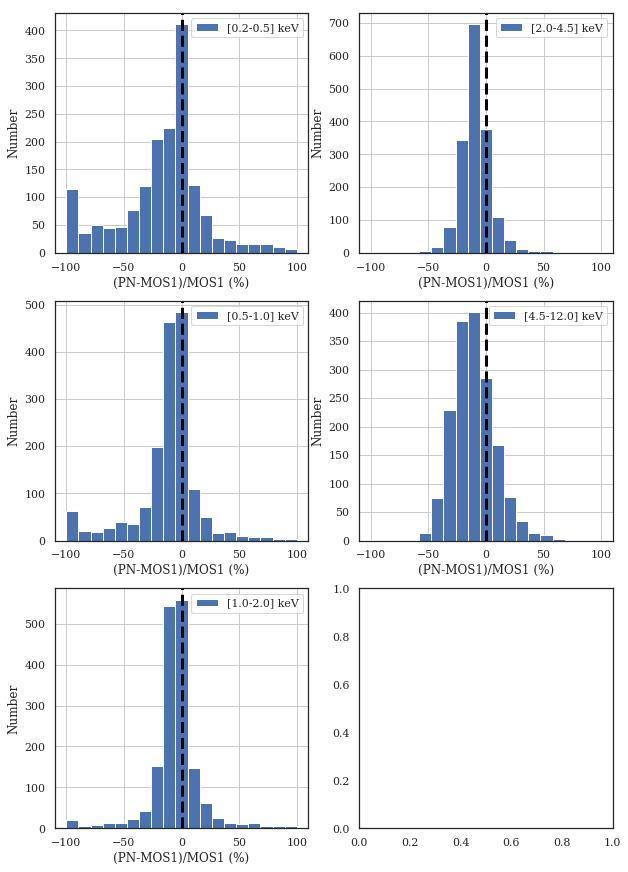

In [66]:
#
# histograms of flux difference (PN-MOS1)/MOS1 in different bands
#
fig, axs = plt.subplots(3,2,figsize=(10,15))
for xband in [1,2,3,4,5]:
    m1_fx = tsel[f'M1_{xband}_FLUX']
    pn_fx = tsel[f'PN_{xband}_FLUX']
    ratio = (pn_fx/m1_fx - 1.0)*100.0 # in percents
    #
    # now the quantiles: median and 
    #
    med, low, up = np.quantile(ratio,[0.5,0.16,0.84])
    print (f"Band {xband} ({bands[xband]}): median={med:.1f}, low(0.16)={low:.1f}, up(0.84)={up:.1f}")
    k = 0
    j = 0
    if (xband > 3):
        k = 1
        j = 3
    #
    _ = axs[xband-j-1,k].hist(ratio,bins=19,range=(-100.0,100.0),label=f'{bands[xband]}')
    axs[xband-j-1,k].axvline(0.0,color='black',linestyle='--',linewidth=3)
    axs[xband-j-1,k].grid()
    axs[xband-j-1,k].legend(loc=1)
    axs[xband-j-1,k].set_xlabel('(PN-MOS1)/MOS1 (%)')
    axs[xband-j-1,k].set_ylabel('Number')
#

In [4]:
t3.info()

<Table masked=True length=775153>
      name        dtype       unit     n_bad 
---------------- ------- ------------- ------
           DETID   int64                    0
           SRCID   int64                    0
        DR3SRCID   int32               376999
        DR3DETID   int32               479614
      DR3DETDIST float32        arcsec      0
      DR3SRCDIST float32        arcsec      0
         DR3MULT   int16               376999
        DR4SRCID   int32               187632
        DR4DETID   int32               247973
      DR4DETDIST float32        arcsec      0
      DR4SRCDIST float32        arcsec      0
         DR4MULT   int16               187632
         IAUNAME bytes21                    0
         SRC_NUM   int16                    0
          OBS_ID bytes10                    0
         REVOLUT  bytes4         orbit      0
       MJD_START float64             d      0
        MJD_STOP float64             d      0
       OBS_CLASS   int16                    0
